In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [162]:
tracks_obj = cl.redo_exclusions(tracks_obj)

Calculating system tracks.


In [169]:
tracks_dir = [
    'two_levels']

years = sorted(list(set(range(1998, 2016)) - {2007, 2008, 2000}))

for d in tracks_dir:
    for year in years:
        path = save_dir + '{}/{}1001_{}0501.pkl'.format(
            d, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)
            
        print('Fixing')
        tracks_obj = cl.redo_exclusions(tracks_obj)
        
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.


In [167]:
tracks_obj.params

{'SEARCH_MARGIN': 50000,
 'FLOW_MARGIN': 40000,
 'MAX_FLOW_MAG': 60,
 'MAX_DISPARITY': 999,
 'MAX_SHIFT_DISP': 60,
 'MAX_SHIFT_DISP_ALT': 25,
 'ISO_SMOOTH': 3,
 'GS_ALT': 1500,
 'LEVELS': array([[  500,  2500],
        [ 2500,  5000],
        [ 5000,  7500],
        [ 7500, 10000]]),
 'MIN_SIZE': [80, 400, 400, 800],
 'FIELD_THRESH': [40, 20, 20, 15],
 'ISO_THRESH': [10, 10, 10, 10],
 'TRACK_INTERVAL': 0,
 'CELL_THRESH': 25,
 'CELL_START': 3000,
 'RAIN': False,
 'SAVE_RAIN': False,
 'AMBIENT': 'ERA5',
 'AMBIENT_BASE_DIR': '/g/data/w40/esh563/era5/pressure-levels/reanalysis/',
 'DT': 10,
 'CLASS_THRESH': {'OFFSET_MAG': 12500,
  'SHEAR_MAG': 3,
  'VEL_MAG': 5,
  'REL_VEL_MAG': 3,
  'ANGLE_BUFFER': 15},
 'EXCL_THRESH': {'SMALL_AREA': 2000,
  'LARGE_AREA': 50000,
  'BORD_THRESH': 0.001,
  'MAJOR_AXIS_LENGTH': 25,
  'AXIS_RATIO': 2,
  'DURATION': 30},
 'BOUNDARY_GRID_CELLS': {(0, 48),
  (0, 49),
  (0, 50),
  (0, 51),
  (0, 52),
  (0, 53),
  (0, 54),
  (0, 55),
  (0, 56),
  (0, 57),
  (0, 58

In [170]:
conv_area_radar = []
strat_area_radar = []
times_radar = []

for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        years_months = [
            [year, 10], [year, 11], [year, 12],
            [year+1, 1], [year+1, 2], [year+1, 3],
            [year+1, 4]]
        for year_month in years_months:
            path = save_dir + 'radar_{}/{}_{}_{:02}.pkl'.format(
                radar, radar, year_month[0], year_month[1])
            with open(path, 'rb') as f:
                tracks_obj = pickle.load(f)

            tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
            print('Fixing.')
            with open(path, 'wb') as f:
                pickle.dump(tracks_obj, f)
                
                
conv_area_ACCESS = []
strat_area_ACCESS = []
times_ACCESS = []

Radar 63, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 63, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.


In [161]:
for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        path = save_dir + 'ACCESS_{}/{}1001_{}0501.pkl'.format(
            radar, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)

        tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
        print('Fixing.')
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Radar 63, year 2020.
Fixing.
Radar 63, year 2021.
Fixing.
Radar 42, year 2020.
Fixing.
Radar 42, year 2021.
Fixing.
Radar 77, year 2020.
Fixing.
Radar 77, year 2021.
Fixing.


In [152]:
conv_area_radar = []
strat_area_radar = []
times_radar = []

for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        years_months = [
            [year, 10], [year, 11], [year, 12],
            [year+1, 1], [year+1, 2], [year+1, 3],
            [year+1, 4]]
        for year_month in years_months:
            path = save_dir + 'radar_{}/{}_{}_{:02}.pkl'.format(
                radar, radar, year_month[0], year_month[1])
            with open(path, 'rb') as f:
                tracks_obj = pickle.load(f)

            exclusions = [
                'small_area', 'large_area', 'intersect_border',
                'intersect_border_convective', 'duration_cond',
                'small_velocity', 'small_offset']
            
            exclusions = [
                'small_area', 'duration_cond']
            
            excluded = tracks_obj.exclusions[exclusions]
            amb = 'Ambiguous (On Quadrant Boundary)'
            # quad_bound = tracks_obj.tracks_class['offset_type'] == amb
            excluded = np.any(excluded, 1)
            included = np.logical_not(excluded)

#             cond = np.logical_and(
#                 tracks_obj.tracks_class['pope_regime']==2,
#                 included==True)
            
            cond = (included==True)
            
            sub_classes = tracks_obj.tracks_class.where(cond).dropna()

            inds_all = sub_classes.index.values
            sub_tracks_all = tracks_obj.tracks.loc[inds_all]
            try:
                sub_tracks_conv = sub_tracks_all.xs(0, level='level')
                sub_tracks_strat = sub_tracks_all.xs(1, level='level')
                conv_area_radar += list(sub_tracks_conv['proj_area'].values)
                strat_area_radar += list(sub_tracks_strat['proj_area'].values)
                times_radar += list(
                    sub_tracks_conv.reset_index()['time'].values)
                
            except KeyError:
                print('No included observations.')

Radar 63, year 2020.
Radar 63, year 2021.
Radar 42, year 2020.
No included observations.
Radar 42, year 2021.
Radar 77, year 2020.
Radar 77, year 2021.


In [153]:
conv_area_ACCESS = []
strat_area_ACCESS = []
times_ACCESS = []

for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        path = save_dir + 'ACCESS_{}/{}1001_{}0501.pkl'.format(
            radar, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)

        exclusions = [
            'small_area', 'large_area', 'intersect_border',
            'intersect_border_convective', 'duration_cond',
            'small_velocity', 'small_offset']
        
        exclusions = [
            'small_area', 'duration_cond']
        
        excluded = tracks_obj.exclusions[exclusions]
        amb = 'Ambiguous (On Quadrant Boundary)'
        # quad_bound = tracks_obj.tracks_class['offset_type'] == amb
        excluded = np.any(excluded, 1)
        included = np.logical_not(excluded)

#         cond = np.logical_and(
#             tracks_obj.tracks_class['pope_regime']==2,
#             included==True)

        cond = (included==True)
            
        sub_classes = tracks_obj.tracks_class.where(cond).dropna()
        inds_all = sub_classes.index.values
        sub_tracks_all = tracks_obj.tracks.loc[inds_all]
        try:
            sub_tracks_conv = sub_tracks_all.xs(0, level='level')
            sub_tracks_strat = sub_tracks_all.xs(1, level='level')
            conv_area_ACCESS += list(sub_tracks_conv['proj_area'].values)
            strat_area_ACCESS += list(sub_tracks_strat['proj_area'].values)
            times_ACCESS += list(sub_tracks_conv.reset_index()['time'].values)
        except KeyError:
            print('No included observations.')

Radar 63, year 2020.
Radar 63, year 2021.
Radar 42, year 2020.
Radar 42, year 2021.
Radar 77, year 2020.
Radar 77, year 2021.


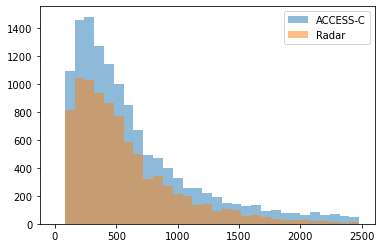

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(conv_area_ACCESS, bins=np.arange(0, 2500, 80), alpha=0.5, label='ACCESS-C')
ax.hist(conv_area_radar, bins=np.arange(0, 2500, 80), alpha=0.5, label='Radar')
plt.legend()

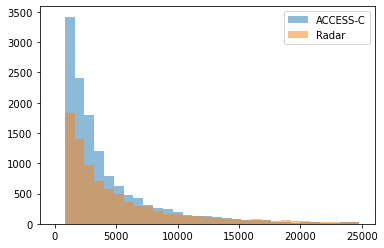

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(strat_area_ACCESS, bins=np.arange(0, 25000, 800), alpha=0.5, label='ACCESS-C')
ax.hist(strat_area_radar, bins=np.arange(0, 25000, 800), alpha=0.5, label='Radar')
plt.legend()

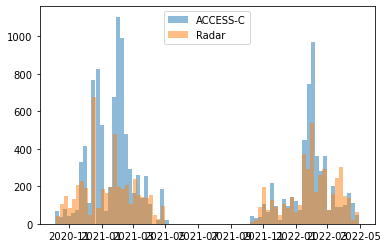

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(times_ACCESS, bins=75, alpha=0.5, label='ACCESS-C')
ax.hist(times_radar, bins=75, alpha=0.5, label='Radar')
plt.legend()

In [132]:
path = save_dir + 'ACCESS_63/20211001_20220501.pkl'
with open(path, 'rb') as f:
    tracks_obj_ACCESS = pickle.load(f)
    
path = save_dir + 'radar_63/63_2022_01.pkl'
with open(path, 'rb') as f:
    tracks_obj_radar = pickle.load(f)

In [133]:
tracks_obj_ACCESS.tracks = tracks_obj_ACCESS.tracks.loc[:,slice(np.datetime64('2022-01-01'), np.datetime64('2022-02-01')),:,:]

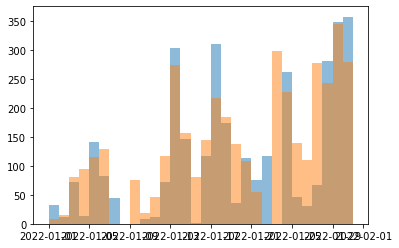

In [135]:
bins = np.arange(np.datetime64('2022-01-01'), np.datetime64('2022-02-01'), np.timedelta64(1, 'D'))

h1 = plt.hist(list(tracks_obj_ACCESS.tracks.xs(0, level='level').reset_index()['time'].values), alpha=0.5, bins=bins)
h1 = plt.hist(list(tracks_obj_radar.tracks.xs(0, level='level').reset_index()['time'].values), alpha=0.5, bins=bins)